In [1]:
import os
import numpy as np
import librosa
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D,
    Bidirectional, LSTM, Dropout, Dense, Lambda, Layer, Masking
)
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import random
import warnings
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [ ]:
# Percorsi dei file
SAVE_DIR    = r"..."
GLOBAL_FILE = os.path.join(SAVE_DIR, "emovo_global_features.xlsx")
LOCAL_FILE  = os.path.join(SAVE_DIR, "emovo_local_features.xlsx")

# Caricamento dei dati
df_global = pd.read_excel(GLOBAL_FILE)
df_local  = pd.read_excel(LOCAL_FILE)

# Divisione dei set di train, validation e test
train_val_speakers = ['f1','f2', 'm1', 'm2', 'm3']
test_speakers      = ['f3'] #Riferimento alla persona f3

# Separazione dei dati per speaker
g_train_val = df_global[df_global['speaker'].isin(train_val_speakers)].reset_index(drop=True)
g_test_i      = df_global[df_global['speaker'].isin(test_speakers)].reset_index(drop=True)

l_train_val = df_local[df_local['speaker'].isin(train_val_speakers)].reset_index(drop=True)
l_test_i      = df_local[df_local['speaker'].isin(test_speakers)].reset_index(drop=True)

# Split train e validation per utterance (file audio)
utterances_tv = g_train_val[['file', 'emotion']].drop_duplicates()

val_utts = (
    utterances_tv.groupby('emotion', group_keys=False)
    .apply(lambda x: x.sample(n=10, random_state=44),include_groups=True)
    .reset_index(drop=True)
)

# Le restanti utterance appartenenti al training set
train_utts = utterances_tv[~utterances_tv['file'].isin(val_utts['file'])].reset_index(drop=True)

train_files = train_utts['file'].tolist()
val_files   = val_utts['file'].tolist()
test_files  = g_test_i['file'].unique().tolist()

# Creazione dei set finali
# Local
l_train_i = l_train_val[l_train_val['file'].isin(train_files)].reset_index(drop=True)
l_val_i   = l_train_val[l_train_val['file'].isin(val_files)].reset_index(drop=True)
# l_test è già pronto

# Normalizzazione per utterance
def normalize_df(df, feature_cols):
    df_norm = df.copy()
    for file_id in df['file'].unique():
        idx = df['file'] == file_id
        scaler = StandardScaler()
        scaler.fit(df.loc[idx, feature_cols])
        df_norm.loc[idx, feature_cols] = scaler.transform(df.loc[idx, feature_cols])
    return df_norm

# Selezionamento delle colonne numeriche da normalizzare
non_feature_cols = ['file', 'emotion', 'speaker', 'utt_id', 'frame']
local_feature_cols  = [col for col in l_train_i.columns if col not in non_feature_cols]

# Local features
l_train_i = normalize_df(l_train_i, local_feature_cols)
l_val_i  = normalize_df(l_val_i, local_feature_cols)
l_test_i = normalize_df(l_test_i, local_feature_cols)

# Verifiche
print(f"Local features:  train={len(l_train_i)},  val={len(l_val_i)},  test={len(l_test_i)}")

print(train_utts.shape, val_utts.shape)
print("Train emotions:", train_utts['emotion'].value_counts())
print("Val emotions:", val_utts['emotion'].value_counts())

print("\nSpeaker distribution in Local sets:")
print("Train :", l_train_i['speaker'].value_counts().to_dict())
print("Val :", l_val_i['speaker'].value_counts().to_dict())
print("Test :", l_test_i['speaker'].value_counts().to_dict())

C:\Users\franc\AppData\Local\Temp\ipykernel_31040\699337267.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=10, random_state=44),include_groups=True)


Local features:  train=162097,  val=28892,  test=38780
(420, 2) (70, 2)
Train emotions: emotion
Anger        60
Disgust      60
Fear         60
Happiness    60
Neutral      60
Sadness      60
Surprise     60
Name: count, dtype: int64
Val emotions: emotion
Anger        10
Disgust      10
Fear         10
Happiness    10
Neutral      10
Sadness      10
Surprise     10
Name: count, dtype: int64

Speaker distribution in Local sets:
Train : {'m1': 42106, 'f1': 32803, 'm2': 29994, 'm3': 28674, 'f2': 28520}
Val : {'m2': 8807, 'm3': 7973, 'f1': 6521, 'f2': 5591}
Test : {'f3': 38780}


In [3]:
# Preparazione sequenze
def prepare_sequences(df, feature_cols, maxlen=None, le=None):
    grouped = df.groupby("file")
    X, y_labels = [], []
    for fname, grp in grouped:
        grp = grp.sort_values("frame")
        X.append(grp[feature_cols].values)
        y_labels.append(grp["emotion"].iloc[0])
    if le is None:
        le = LabelEncoder()
        y_enc = le.fit_transform(y_labels)
    else:
        y_enc = le.transform(y_labels)
    y_cat = to_categorical(y_enc)
    if maxlen is None:
        maxlen = max(len(x) for x in X)
    X_pad = pad_sequences(X, maxlen=maxlen, padding="post", dtype="float32")
    return X_pad, y_cat, le, maxlen

feature_cols = [c for c in l_train_i.columns if c.startswith("mfcc") or 
                                                 c.startswith("logmel") or 
                                                 c.startswith("dmfcc") or 
                                                 c.startswith("dlogmel")]

X_train, y_train, label_enc, MAXLEN = prepare_sequences(l_train_i, feature_cols)
X_val,   y_val,   _,         _      = prepare_sequences(l_val_i, feature_cols, maxlen=MAXLEN, le=label_enc)
X_test,  y_test,  _,         _      = prepare_sequences(l_test_i, feature_cols, maxlen=MAXLEN, le=label_enc)

# Calcolo dei pesi delle classi
num_classes = y_train.shape[1]
cw = compute_class_weight("balanced", classes=np.arange(num_classes), y=np.argmax(y_train, axis=1))
class_weight = {i: float(w * 0.5) for i, w in enumerate(cw)}

# Livello di attenzione additiva
class AdditiveAttentionLayer(Layer):
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.d1 = Dense(units, activation="tanh")
        self.d2 = Dense(1)
        self.sm = tf.keras.layers.Softmax(axis=1)
    def call(self, inputs):
        s = self.d1(inputs)
        s = self.d2(s)
        w = self.sm(s)
        return tf.reduce_sum(inputs * w, axis=1)

# Modello
inp = Input(shape=(MAXLEN, len(feature_cols)))

# CNN
x = Conv1D(64, 5, padding="same", activation="relu")(inp)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, 5, padding="same", activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)

# BLSTM
mask = Lambda(lambda t: tf.math.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x, mask=mask)
x = Dropout(0.5)(x)

# Attention + Dense
x = AdditiveAttentionLayer(units=64)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(1e-3), name="dense_embed")(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Output
out = Dense(num_classes, activation="softmax")(x)

# Compilazione
model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


# Addestramento del Modello
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau("val_loss", factor=0.5, patience=4, min_lr=1e-8, verbose=1),
    tf.keras.callbacks.EarlyStopping("val_loss", patience=15, restore_best_weights=True, verbose=1)
]
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=100, batch_size=16,
                    class_weight=class_weight,
                    callbacks=callbacks, verbose=2)

# Valutazione del Modello
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.3f}, Test loss: {test_loss:.3f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1750, 46)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1750, 64)  │     14,784 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1750, 64)  │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 875, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 875, 64)   │     20,544 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 875, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 437, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1750)      │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 437, 256)  │    197,632 │ max_pooling1d_1[… │
│ (Bidirectional)     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 437, 256)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, 256)       │     16,513 │ dropout[0][0]     │
│ (AdditiveAttention… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_embed (Dense) │ (None, 64)        │     16,448 │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_embed[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 7)         │        455 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 267,144 (1.02 MB)

 Trainable params: 266,760 (1.02 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
27/27 - 13s - 466ms/step - accuracy: 0.1643 - loss: 1.1277 - val_accuracy: 0.1714 - val_loss: 2.0452 - learning_rate: 1.0000e-04
Epoch 2/100
27/27 - 7s - 268ms/step - accuracy: 0.1762 - loss: 1.0748 - val_accuracy: 0.1429 - val_loss: 2.0430 - learning_rate: 1.0000e-04
Epoch 3/100
27/27 - 9s - 321ms/step - accuracy: 0.1595 - loss: 1.0766 - val_accuracy: 0.1429 - val_loss: 2.0417 - learning_rate: 1.0000e-04
Epoch 4/100
27/27 - 11s - 397ms/step - accuracy: 0.2167 - loss: 1.0442 - val_accuracy: 0.1429 - val_loss: 2.0399 - learning_rate: 1.0000e-04
Epoch 5/100
27/27 - 9s - 335ms/step - accuracy: 0.2310 - loss: 1.0414 - val_accuracy: 0.1429 - val_loss: 2.0383 - learning_rate: 1.0000e-04
Epoch 6/100
27/27 - 10s - 352ms/step - accuracy: 0.2571 - loss: 1.0187 - val_accuracy: 0.1571 - val_loss: 2.0329 - learning_rate: 1.0000e-04
Epoch 7/100
27/27 - 9s - 333ms/step - accuracy: 0.2881 - loss: 0.9919 - val_accuracy: 0.1571 - val_loss: 2.0273 - learning_rate: 1.0000e-04
Epoch 8/100
27/27

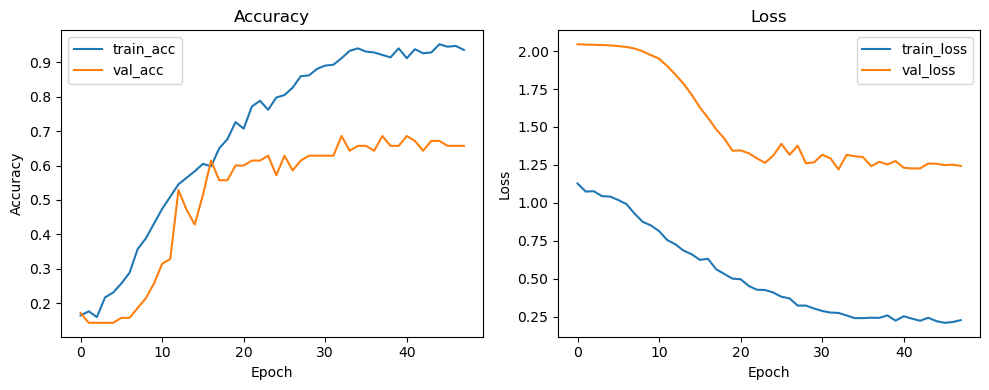


 Test accuracy: 0.347  –  loss: 2.054
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step


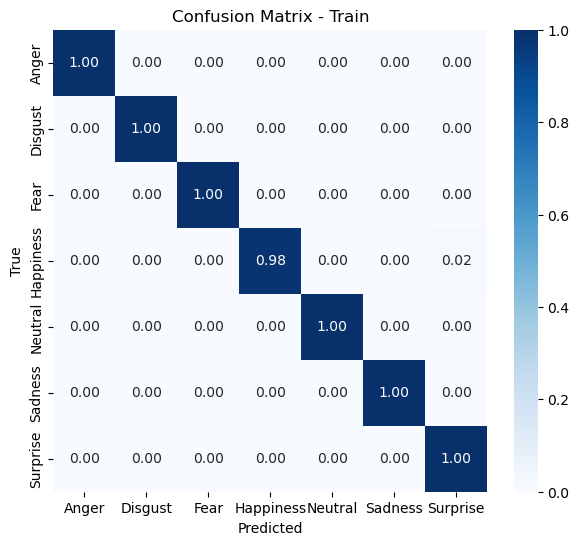

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


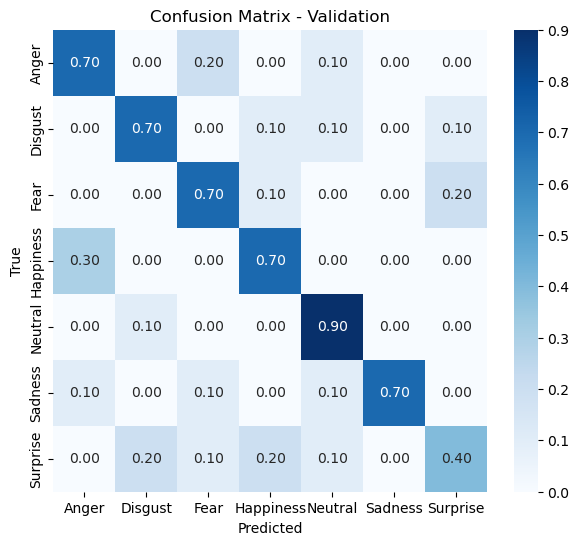

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 


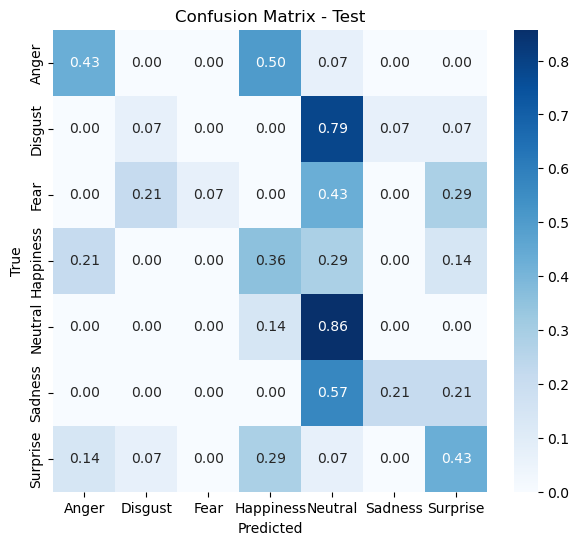

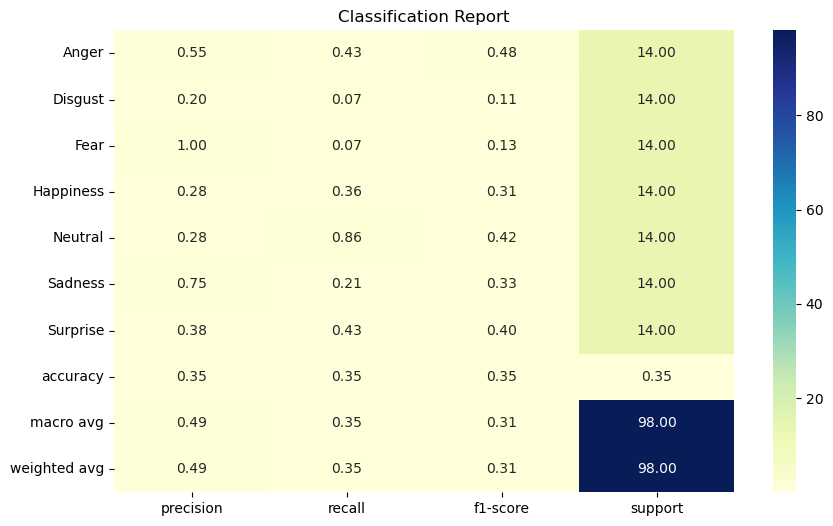

In [5]:
# Curve Accuracy & Loss
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Valutazione su Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n Test accuracy: {test_acc:.3f}  –  loss: {test_loss:.3f}")

# Codifica delle classi
label_names = label_enc.classes_

# Funzione per matrici normalizzate
def plot_conf_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, normalize='true')  # percentuali riga per riga
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Confusion Matrix - TRAIN
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_train_true = np.argmax(y_train, axis=1)
plot_conf_matrix(y_train_true, y_train_pred, label_names, 'Confusion Matrix - Train')

# Confusion Matrix - VALIDATION
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)
plot_conf_matrix(y_val_true, y_val_pred, label_names, 'Confusion Matrix - Validation')

# Confusion Matrix - TEST
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_test_true = np.argmax(y_test, axis=1)
plot_conf_matrix(y_test_true, y_test_pred, label_names, 'Confusion Matrix - Test')

# CLASSIFICATION REPORT
report_dict = classification_report(
    y_test_true,
    y_test_pred,
    target_names=label_names,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Heatmap
report_df_filtered = report_df
heatmap_data = report_df_filtered

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Classification Report")
plt.show()